# Modifying FastPitch to Train on a Chinese and English Bilingual Dataset

This notebook is designed to provide a guide on how to train FastPitch on a Chinese and English bilingual dataset from scratch as part of the TTS pipeline. It contains the following sections:
  1. **Introduction**: FastPitch and HiFi-GAN in NeMo
  2. **Dataset Preparation**: How to prepare Chinese dataset for FastPitch
  3. **Training**: Example of FastPitch training and evaluation
  4. **(TODO) Finetuning from LJSpeech Acoustic Model**: Improving English speech quality by finetuning LJ Speech pretrained model

# License

> Copyright 2022 NVIDIA. All Rights Reserved.
> 
> Licensed under the Apache License, Version 2.0 (the "License");
> you may not use this file except in compliance with the License.
> You may obtain a copy of the License at
> 
>     http://www.apache.org/licenses/LICENSE-2.0
> 
> Unless required by applicable law or agreed to in writing, software
> distributed under the License is distributed on an "AS IS" BASIS,
> WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
> See the License for the specific language governing permissions and
> limitations under the License.

In [1]:
"""
You can either run this notebook locally (if you have all the dependencies and a GPU) or on Google Colab.
Instructions for setting up Colab are as follows:
1. Open a new Python 3 notebook.
2. Import this notebook from GitHub (File -> Upload Notebook -> "GITHUB" tab -> copy/paste GitHub URL)
3. Connect to an instance with a GPU (Runtime -> Change runtime type -> select "GPU" for hardware accelerator)
4. Run this cell to set up dependencies# .
"""
BRANCH = 'main'
# # If you're using Colab and not running locally, uncomment and run this cell.
# !apt-get install sox libsndfile1 ffmpeg
# !pip install wget text-unidecode pynini==2.1.4 scipy==1.7.3
# !python -m pip install git+https://github.com/NVIDIA/NeMo.git@$BRANCH#egg=nemo_toolkit[all]
# !wget https://raw.githubusercontent.com/NVIDIA/NeMo/main/nemo_text_processing/install_pynini.sh
# !bash install_pynini.sh
# !pip install pypinyin opencc-python-reimplemented

In [1]:
import json
import nemo
import torch
import librosa
import numpy as np

from pathlib import Path
from tqdm.notebook import tqdm

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.12) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [2]:
# let's download the files we need to run this tutorial

!mkdir -p NeMoChineseTTS
!cd NeMoChineseTTS && wget https://raw.githubusercontent.com/nvidia/NeMo/$BRANCH/scripts/tts_dataset_files/zh/pinyin_dict.txt
!cd NeMoChineseTTS && wget https://raw.githubusercontent.com/nvidia/NeMo/$BRANCH/scripts/dataset_processing/tts/sfbilingual/get_data.py
!cd NeMoChineseTTS && wget https://raw.githubusercontent.com/nvidia/NeMo/$BRANCH/examples/tts/fastpitch.py
!cd NeMoChineseTTS && wget https://raw.githubusercontent.com/nvidia/NeMo/$BRANCH/examples/tts/hifigan_finetune.py
!cd NeMoChineseTTS && wget https://raw.githubusercontent.com/nvidia/NeMo/$BRANCH/scripts/dataset_processing/tts/extract_sup_data.py
!cd NeMoChineseTTS && wget https://raw.githubusercontent.com/nvidia/NeMo/$BRANCH/scripts/dataset_processing/tts/sfbilingual/ds_conf/ds_for_fastpitch_align.yaml
!cd NeMoChineseTTS && wget https://raw.githubusercontent.com/NVIDIA/NeMo/$BRANCH/examples/tts/conf/zh/fastpitch_align_22050.yaml
!cd NeMoChineseTTS && wget https://raw.githubusercontent.com/NVIDIA/NeMo/$BRANCH/examples/tts/conf/hifigan/hifigan.yaml
!cd NeMoChineseTTS && wget https://raw.githubusercontent.com/NVIDIA/NeMo/$BRANCH/nemo_text_processing/text_normalization/zh/data/whitelist/default.tsv
!cd NeMoChineseTTS && mkdir -p model/train_ds && cd model/train_ds && wget https://raw.githubusercontent.com/nvidia/NeMo/$BRANCH/examples/tts/conf/hifigan/model/train_ds/train_ds_finetune.yaml
!cd NeMoChineseTTS && mkdir -p model/validation_ds && cd model/validation_ds && wget https://raw.githubusercontent.com/nvidia/NeMo/$BRANCH/examples/tts/conf/hifigan/model/validation_ds/val_ds_finetune.yaml
!cd NeMoChineseTTS && mkdir -p model/generator && cd model/generator && wget https://raw.githubusercontent.com/nvidia/NeMo/$BRANCH/examples/tts/conf/hifigan/model/generator/v1.yaml

# Introduction

### FastPitch

FastPitch is non-autoregressive model for mel-spectrogram generation based on FastSpeech, conditioned on fundamental frequency contours. For more details about model, please refer to the original [paper](https://ieeexplore.ieee.org/abstract/document/9413889). Original [FastPitch model](https://ieeexplore.ieee.org/abstract/document/9413889) uses an external Tacotron 2 model trained on LJSpeech-1.1 to extract training alignments and estimate durations of input symbols. This implementation of FastPitch is based on [Deep Learning Examples](https://github.com/NVIDIA/DeepLearningExamples/tree/master/PyTorch/SpeechSynthesis/FastPitch), which uses an alignment mechanism proposed in [RAD-TTS](https://openreview.net/pdf?id=0NQwnnwAORi) and extended in [TTS Aligner](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=9747707).

For more information on training a basic FastPitch model, please refer to [FastPitch_MixerTTS_Training.ipynb](https://github.com/NVIDIA/NeMo/blob/main/tutorials/tts/FastPitch_MixerTTS_Training.ipynb) tutorial.

### HiFiGAN
HiFiGAN is a generative adversarial network (GAN) model that generates audio from mel spectrograms. The generator uses transposed convolutions to upsample mel spectrograms to audio. For more details about the model, please refer to the original [paper](https://arxiv.org/abs/2010.05646). NeMo re-implementation of HiFi-GAN can be found [here](https://github.com/NVIDIA/NeMo/blob/main/nemo/collections/tts/models/hifigan.py).

# Dataset Preparation

We will show example of preprocessing and training using SF Bilingual Speech TTS dataset ([link](https://catalog.ngc.nvidia.com/orgs/nvidia/resources/sf_bilingual_speech_zh_en)). The dataset contains about 2,740 bilingual audio samples of a single female speaker and their corresponding text transcripts, each of them is an audio of around 5-6 seconds and have a total length of approximately 4.5 hours.

In this section, we will cover:
1. Downloading the dataset
2. Creating manifests
3. Normalizing text
4. Phonemization
5. Creating dataset config
6. Creating supplementary data

## 1. Downloading the dataset

In [ ]:
!cd NeMoChineseTTS && mkdir DataChinese && \
    cd DataChinese && \
    ngc registry resource download-version "nvidia/sf_bilingual_speech_zh_en:v1" && \
    unzip SF_bilingual.zip

In [3]:
# DataChineseTTS directory looks like
!ls NeMoChineseTTS/DataChinese -R

NeMoChineseTTS/DataChinese:
sf_bilingual_speech_zh_en_vv1

NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1:
SF_bilingual  SF_bilingual.zip

NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual:
cache_dir  eval_filelist.txt  text_SF.txt  train_filelist.txt  wavs

NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/cache_dir:
zh_tn_True_deterministic_verbalizer.far

NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs:
com_SF_ce1.wav	   com_SF_ce1615.wav  com_SF_ce2231.wav  com_SF_ce381.wav
com_SF_ce10.wav    com_SF_ce1616.wav  com_SF_ce2232.wav  com_SF_ce382.wav
com_SF_ce100.wav   com_SF_ce1617.wav  com_SF_ce2233.wav  com_SF_ce383.wav
com_SF_ce1000.wav  com_SF_ce1618.wav  com_SF_ce2234.wav  com_SF_ce384.wav
com_SF_ce1001.wav  com_SF_ce1619.wav  com_SF_ce2235.wav  com_SF_ce385.wav
com_SF_ce1002.wav  com_SF_ce162.wav   com_SF_ce2236.wav  com_SF_ce386.wav
com_SF_ce1003.wav  com_SF_ce1620.wav  com_SF_ce2237.wav  com_SF_ce387.

## 2. Creating manifests 

We've created `scripts/dataset_processing/tts/sfbilingual/get_data.py` script that reads the `DataChineseTTS/SF_bilingual/text_SF.txt` provided with the dataset and generates the following fields per each datapoint:
1. `audio_filepath`: location of the wav file
2. `duration`: duration of the wav file
3. `text`: original text supplied by SF dataset
    
After that, the script would splits the datapoints into 3 buckets `train_manifest.json`, `val_manifest.json` and `test_manifest.json`, respectively.

In [ ]:
!(cd NeMoChineseTTS && \
    python get_data.py \
        --data-root ./DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/
        --manifests-path ./)

In the example above, 0.5% datapoints go to validation set, 1% go to test set and the remaining 98.5% go to training set.

In [4]:
# NeMoChineseTTS directory looks like
!ls NeMoChineseTTS -R

NeMoChineseTTS:
DataChinese		     get_data.py	  test_manifest.json
default.tsv		     hifigan.yaml	  train_ds_finetune.yaml
ds_for_fastpitch_align.yaml  hifigan_finetune.py  train_manifest.json
extract_sup_data.py	     pinyin_dict.txt	  v1.yaml
fastpitch.py		     resultChineseTTS	  val_ds_finetune.yaml
fastpitch_align_22050.yaml   sup-data-phonemes	  val_manifest.json

NeMoChineseTTS/DataChinese:
sf_bilingual_speech_zh_en_vv1

NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1:
SF_bilingual  SF_bilingual.zip

NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual:
cache_dir  eval_filelist.txt  text_SF.txt  train_filelist.txt  wavs

NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/cache_dir:
zh_tn_True_deterministic_verbalizer.far

NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs:
com_SF_ce1.wav	   com_SF_ce1615.wav  com_SF_ce2231.wav  com_SF_ce381.wav
com_SF_ce10.wav    com_SF_ce1616.wav  com_SF_ce2232.wav  com_SF_ce382

## 3. Normalizing text

The script above, i.e. `scripts/dataset_processing/tts/sfbilingual/get_data.py`, also generates another field per each datapoint:
- `normalized_text`: normalized text via NeMo's text normalizer:
    ```python
    nemo_text_processing.text_normalization.normalize.Normalizer(lang="zh", input_case="cased", overwrite_cache=True, cache_dir=str(file_path / "cache_dir"))
    ```
    
Chinese language text normalizer (defined here: `nemo_text_processing/text_normalization/zh`) was created using the tutorial shared under NeMo's `Chinese customization` documentation [here](https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/main/nlp/text_normalization/wfst/wfst_text_normalization.html#grammar-customization). 

<!-- Here are some example records:
```json
{"audio_filepath": "DataGermanTTS/thorsten-de/wavs/f1becc89cb4079a123ead68c9c8bb8ae.wav", "duration": 7.250023, "text": "Öffne den Webbrowser und rufe www.archlinux.org auf.", "normalized_text": "Öffne den Webbrowser und rufe w w w punkt a r c h l i n u x punkt o r g auf."}
``` -->

## 4. Phonemization

The pronunciation of a Chinese sentence can be represented as a string of phones. We would first convert a sentence into a pinyin seqences by using pypinyin library. Then we use a pre-defined pinyin-to-phoneme dict to convert them into phonemes. For English words in the sentences, we would directly use letters as input units.

In [5]:
print("text: 我今天去了Apple Store, 买了一个ihone。")
print("pinyin: 'wo3', 'jin1', 'tian1', 'qu4', 'le5', 'A', 'p', 'p', 'l', 'e', ' ', 'S', 't', 'o', 'r', 'e', ',', ' ', 'mai3', 'le5', 'yi2', 'ge4', 'i', 'h', 'o', 'n', 'e', '。'")

text: 我今天去了Apple Store, 买了一个ihone。
pinyin: 'wo3', 'jin1', 'tian1', 'qu4', 'le5', 'A', 'p', 'p', 'l', 'e', ' ', 'S', 't', 'o', 'r', 'e', ',', ' ', 'mai3', 'le5', 'yi2', 'ge4', 'i', 'h', 'o', 'n', 'e', '。'


The original JSON dataset split generated from `get_data.py` only contains text/grapheme inputs. We recommend using phonemes as well to obtain better quality of synthesized audios. The tutorial uses Chinese phonemes and English letters as modeling unit by default.

## 5. Creating dataset config

Most of the configuration remains the same as described in [FastPitch and MixerTTS training tutorial](FastPitch_MixerTTS_Training.ipynb) except:
1. The `text_tokenizer._target_` is set to `nemo.collections.common.tokenizers.text_to_speech.tts_tokenizers.ChinesePhonemesTokenizer` class defined here: `collections/common/tokenizers/text_to_speech/tts_tokenizers.py`.

2. The `text_normalizer.lang` is set to `zh`, in order to use the tokenizer defined in `nemo_text_processing/text_normalization/zh` (as discussed above).

3. Update the `whitelist_path` to point to Chinese whitelist: `nemo_text_processing/text_normalization/zh/data/whitelist/default.tsv`

Final config looks like:

```yaml
name: "ds_for_fastpitch_align"

manifest_filepath: "train_manifest.json"
sup_data_path: "sup_data"
sup_data_types: [ "align_prior_matrix", "pitch" ]
whitelist_path: "nemo_text_processing/text_normalization/zh/data/whitelist/default.tsv"

phoneme_dict_path: "scripts/tts_dataset_files/zh/pinyin_dict.txt"

dataset:
  _target_: nemo.collections.tts.torch.data.TTSDataset
  manifest_filepath: ${manifest_filepath}
  sample_rate: 22050
  sup_data_path: ${sup_data_path}
  sup_data_types: ${sup_data_types}
  n_fft: 1024
  win_length: 1024
  hop_length: 256
  window: "hann"
  n_mels: 80
  lowfreq: 0
  highfreq: null
  max_duration: null
  min_duration: 0.1
  ignore_file: null
  trim: false
  pitch_fmin: 65.40639132514966
  pitch_fmax: 2093.004522404789

  text_normalizer:
    _target_: nemo_text_processing.text_normalization.normalize.Normalizer
    lang: zh
    input_case: cased
    whitelist: ${whitelist_path}

  text_normalizer_call_kwargs:
    verbose: false
    punct_pre_process: true
    punct_post_process: true

  text_tokenizer:
    _target_: nemo.collections.common.tokenizers.text_to_speech.tts_tokenizers.ChinesePhonemesTokenizer
    punct: true
    apostrophe: true
    pad_with_space: true
    g2p:
      _target_: nemo_text_processing.g2p.modules.ChineseG2p
      phoneme_dict: ${phoneme_dict_path}
```

Save the above config in `NeMoChineseTTS/ds_for_fastpitch_align.yaml`.

## 6. Creating Supplementary Data

As mentioned in the [FastPitch and MixerTTS training tutorial](FastPitch_MixerTTS_Training.ipynb) - To accelerate and stabilize our training, we also need to extract pitch for every audio, estimate pitch statistics (mean and std) and pre-calculate alignment prior matrices for alignment framework. To do this, all we need to do is iterate over our data one time, via `extract_sup_data.py` script.

Note: This is an optional step, if skipped, it will be automatically executed within the first epoch of training FastPitch.

In [ ]:
!cd NeMoChineseTTS && python extract_sup_data.py \
        --config-path . \
        --config-name ds_for_fastpitch_align.yaml \
        manifest_filepath=./train_manifest.json \
        sup_data_path=./sup-data-phonemes/ \
        phoneme_dict_path=./pinyin_dict.txt 

The above example gives the following result:
1. Creates two folders under `sup_data_path` - `pitch` and `align_prior_matrix`
2. Prints out some values for pitch mean and standard deviation: `PITCH_MEAN, PITCH_STD = 221.4948272705078, 64.65289306640625 `. Use these values while training FastPitch.

# Training

Before we train our model, let's define model config. Most of the model config stays the same as defined here: `examples/tts/conf/fastpitch_align_44100.yaml`, except:
1. Make the same changes that we made in dataset config for `text_tokenizer`, `text_normalizer` and `whitelist_path`.

2. The `pitch_mean` and `pitch_std` are updated to the values reported by the `extract_sup_data.py` script.

3. The `sample_rate` is updated to 22050 KHz per our dataset. And accordingly halve the `n_window_size`, `n_window_stride` and `n_fft` parameters as well. 

We have already downloaded the config after making these changes here: `NeMoChineseTTS/fastpitch_align_22050.yaml`

In [6]:
!cat NeMoChineseTTS/fastpitch_align_22050.yaml

cat: NeMoChineseTTS/fastpitch_align_22050.yaml: No such file or directory


If you are using Weights and Biases, you may need to login first. More details [here](https://docs.wandb.ai/ref/cli/wandb-login).

In [ ]:
!wandb login #paste_wandb_apikey_here

Now we are ready for training our model! Let's try to train FastPitch. Paste the PITCH_MEAN and PITCH_STD from previous steps here.

In [ ]:
!(cd NeMoChineseTTS && CUDA_VISIBLE_DEVICES=0 python fastpitch.py --config-path . --config-name fastpitch_align_22050 \
    model.train_ds.dataloader_params.batch_size=32 \
    model.validation_ds.dataloader_params.batch_size=8 \
    train_dataset=./train_manifest.json \
    validation_datasets=./val_manifest.json \
    sup_data_path=./sup-data-phonemes \
    whitelist_path=./default.tsv \
    exp_manager.exp_dir=resultChineseTTS \
    trainer.max_epochs=1 \
    trainer.check_val_every_n_epoch=1 \
    pitch_mean=221.4948272705078 #paste_pitch_mean_here \
    pitch_std=64.65289306640625 #paste_pitch_std_here \
    phoneme_dict_path=./pinyin_dict.txt \
    +exp_manager.create_wandb_logger=true \
    +exp_manager.wandb_logger_kwargs.name="tutorial" \
    +exp_manager.wandb_logger_kwargs.project="ChineseTTS")

Note:
1. We use `CUDA_VISIBLE_DEVICES=0` to limit training to single GPU.
2. For debugging you may also add the following flags: `HYDRA_FULL_ERROR=1`, `CUDA_LAUNCH_BLOCKING=1`

<b>Note</b>: We've limited the above run to 1 epoch only, so we can validate the implementation within the scope of this tutorial. We recommend around 1000 epochs when training FastPitch from scratch.

## Evaluating FastPitch + pretrained HiFi-GAN

Let's evaluate the quality of the FastPitch model generated so far using a HiFi-GAN model pre-trained on English.

In [2]:
import IPython.display as ipd
from nemo.collections.tts.models import HifiGanModel, FastPitchModel
from matplotlib.pyplot import imshow
from matplotlib import pyplot as plt

[NeMo W 2022-10-21 08:25:41 optimizers:55] Apex was not found. Using the lamb or fused_adam optimizer will error out.
[NeMo W 2022-10-21 08:25:42 experimental:27] Module <class 'nemo_text_processing.g2p.modules.IPAG2P'> is experimental, not ready for production and is not fully supported. Use at your own risk.
[NeMo W 2022-10-21 08:25:42 experimental:27] Module <class 'nemo.collections.common.tokenizers.text_to_speech.tts_tokenizers.IPATokenizer'> is experimental, not ready for production and is not fully supported. Use at your own risk.
[NeMo W 2022-10-21 08:25:42 experimental:27] Module <class 'nemo.collections.tts.models.radtts.RadTTSModel'> is experimental, not ready for production and is not fully supported. Use at your own risk.


In [7]:
hfg_ngc = "tts_hifigan" # NGC pretrained model name: https://catalog.ngc.nvidia.com/orgs/nvidia/teams/nemo/models/tts_hifigan 
# from the results directory "<path_to_fastpitch_nemo_or_ckpt>"
fastpitch_model_path = "NeMoChineseTTS/resultChineseTTS/FastPitch/2022-10-20_07-13-08/checkpoints/FastPitch.nemo" 
test = "NTHU對面有一條宵夜街。" # text input to the model
test_id = "com_SF_ce1" # identifier for the audio corresponding to the test text
data_path = "NeMoChineseTTS/DataChineseTTS/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/" # path to dataset folder with wav files from original dataset
seed = 1234

In [4]:
def evaluate_spec_fastpitch_ckpt(spec_gen_model, v_model, test):
    with torch.no_grad():
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.enabled = True
        torch.backends.cudnn.benchmark = False
        parsed = spec_gen_model.parse(str_input=test, normalize=True)
        spectrogram = spec_gen_model.generate_spectrogram(tokens=parsed)
        print(spectrogram.size())
        audio = v_model.convert_spectrogram_to_audio(spec=spectrogram)

    spectrogram = spectrogram.to('cpu').numpy()[0]
    audio = audio.to('cpu').numpy()[0]
    audio = audio / np.abs(audio).max()
    return audio, spectrogram

In [5]:
# load models
vocoder_model = HifiGanModel.from_pretrained(hfg_ngc, strict=False).eval().cuda()
if ".nemo" in fastpitch_model_path:
    spec_gen_model = FastPitchModel.restore_from(fastpitch_model_path).eval().cuda()
else:
    spec_gen_model = FastPitchModel.load_from_checkpoint(checkpoint_path=fastpitch_model_path).eval().cuda()

[NeMo I 2022-10-21 08:25:50 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.13.0rc0/tts_hifigan/e6da322f0f7e7dcf3f1900a9229a7e69/tts_hifigan.nemo.
[NeMo I 2022-10-21 08:25:50 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.13.0rc0/tts_hifigan/e6da322f0f7e7dcf3f1900a9229a7e69/tts_hifigan.nemo
[NeMo I 2022-10-21 08:25:50 common:911] Instantiating model from pre-trained checkpoint


[NeMo W 2022-10-21 08:25:54 modelPT:142] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    dataset:
      _target_: nemo.collections.tts.data.datalayers.MelAudioDataset
      manifest_filepath: /home/fkreuk/data/train_finetune.txt
      min_duration: 0.75
      n_segments: 8192
    dataloader_params:
      drop_last: false
      shuffle: true
      batch_size: 64
      num_workers: 4
    
[NeMo W 2022-10-21 08:25:54 modelPT:149] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 
    Validation config : 
    dataset:
      _target_: nemo.collections.tts.data.datalayers.MelAudioDataset
      manifest_filepath: /home/fkreuk/data/val_finetune.txt
      min_duration: 3
      n_segments: 66150


[NeMo I 2022-10-21 08:25:55 features:225] PADDING: 0


[NeMo W 2022-10-21 08:25:55 features:202] Using torch_stft is deprecated and has been removed. The values have been forcibly set to False for FilterbankFeatures and AudioToMelSpectrogramPreprocessor. Please set exact_pad to True as needed.


[NeMo I 2022-10-21 08:25:55 features:225] PADDING: 0
[NeMo I 2022-10-21 08:26:02 save_restore_connector:243] Model HifiGanModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.13.0rc0/tts_hifigan/e6da322f0f7e7dcf3f1900a9229a7e69/tts_hifigan.nemo.


[NeMo W 2022-10-21 08:26:05 modules:534] apply_to_oov_word=None, This means that some of words will remain unchanged if they are not handled by any of the rules in self.parse_one_word(). This may be intended if phonemes and chars are both valid inputs, otherwise, you may see unexpected deletions in your input.
[NeMo W 2022-10-21 08:26:05 modelPT:142] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    dataset:
      _target_: nemo.collections.tts.torch.data.TTSDataset
      manifest_filepath: ./train_manifest.json
      sample_rate: 22050
      sup_data_path: ./sup-data-phonemes
      sup_data_types:
      - align_prior_matrix
      - pitch
      n_fft: 1024
      win_length: 1024
      hop_length: 256
      window: hann
      n_mels: 80
      lowfreq: 0
      highfreq: null
      max_duration: 14
      min_duration: 0.1
      ignore_file: null
  

[NeMo I 2022-10-21 08:26:05 features:225] PADDING: 1
[NeMo I 2022-10-21 08:26:06 save_restore_connector:243] Model FastPitchModel was successfully restored from /mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/resultChineseTTS/FastPitch/2022-10-20_07-13-08/checkpoints/FastPitch.nemo.


torch.Size([1, 80, 286])


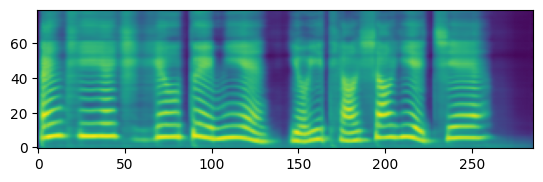

original audio


ValueError: could not convert string to float: 'NeMoChineseTTS/DataChineseTTS/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce1.wav'

In [8]:
%matplotlib inline

audio, spectrogram = evaluate_spec_fastpitch_ckpt(spec_gen_model, vocoder_model, test)

# visualize the spectrogram
if spectrogram is not None:
    imshow(spectrogram, origin="lower")
    plt.show()

# audio
print("original audio")
ipd.display(ipd.Audio(data_path+test_id+'.wav', rate=22050))
print("predicted audio")
ipd.display(ipd.Audio(audio, rate=22050))

We see that audio quality is not as good as we expect, even after training FastPitch for 1000 epochs. One of the ways mentioned in the [FastPitch_Finetuning.ipynb](FastPitch_Finetuning.ipynb) tutorial is to finetune HiFi-GAN. Lets try that out next!

# Finetuning HiFi-GAN

Improving speech quality by Finetuning HiFi-GAN on synthesized mel-spectrograms from FastPitch. 

## Generating synthetic mels

To generate mel-spectrograms from FastPitch, we can use `generate_spectrogram` method defined in `nemo/collections/tts/models/fastpitch.py`. However, the resulting spectrogram may be different from ground truth mel spectrogram, as shown below:

In [7]:
test_audio_filepath = "NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce1.wav"
test_audio_text = "NTHU對面有一條宵夜街。"
fastpitch_model_path = "<path_to_fastpitch_nemo>"

In [ ]:
from matplotlib.pyplot import imshow
from nemo.collections.tts.models import FastPitchModel
from matplotlib import pyplot as plt
import librosa
import librosa.display
import torch
import soundfile as sf
import numpy as np
from nemo.collections.tts.torch.helpers import BetaBinomialInterpolator

def load_wav(audio_file):
    with sf.SoundFile(audio_file, 'r') as f:
        samples = f.read(dtype='float32')
    return samples.transpose()

def plot_logspec(spec, axis=None):    
    librosa.display.specshow(
        librosa.amplitude_to_db(spec, ref=np.max),
        y_axis='linear', 
        x_axis="time",
        fmin=0, 
        fmax=8000,
        ax=axis
    )

In [ ]:
spec_model = FastPitchModel.restore_from(fastpitch_model_path).eval().cuda()

So we have 2 types of mel spectrograms that we can use for finetuning HiFi-GAN:

### 1. Original mel spectrogram generated from original audio file

In [ ]:
print("loading original melspec")
y, sr = librosa.load(test_audio_filepath)
# change n_fft, win_length, hop_length parameters below based on your specific config file
spectrogram2 = np.log(librosa.feature.melspectrogram(y=y, sr=sr, n_fft=1024, win_length=1024, hop_length=256))
spectrogram = spectrogram2[ :80, :]
print("spectrogram shape = ", spectrogram.shape)
plot_logspec(spectrogram)
plt.show()

### 2. Mel spectrogram predicted from FastPitch

In [ ]:
print("loading fastpitch melspec via generate_spectrogram")
with torch.no_grad():
    text = spec_model.parse(test_audio_text, normalize=False)
    spectrogram = spec_model.generate_spectrogram(
      tokens=text, 
      speaker=None,
    )
spectrogram = spectrogram.to('cpu').numpy()[0]
plot_logspec(spectrogram)
print("spectrogram shape = ", spectrogram.shape)
plt.show()

<b>Note</b>: The above spectrogram has the duration 291 which is not equal to the ground truth length, i.e. 315. In order to finetune HiFi-GAN we need mel spectrogram predicted from FastPitch with groundtruth alignment and duration.

### 2.1 Mel spectrogram predicted from FastPitch with groundtruth alignment and duration 

In [ ]:
print("loading fastpitch melspec via forward method with groundtruth alignment and duration")
with torch.no_grad():
    device = spec_model.device
    beta_binomial_interpolator = BetaBinomialInterpolator()
    text = spec_model.parse(test_audio_text, normalize=False)
    text_len = torch.tensor(text.shape[-1], dtype=torch.long, device=device).unsqueeze(0)
    audio = load_wav(test_audio_filepath)
    audio = torch.from_numpy(audio).unsqueeze(0).to(device)
    audio_len = torch.tensor(audio.shape[1], dtype=torch.long, device=device).unsqueeze(0)
    spect, spect_len = spec_model.preprocessor(input_signal=audio, length=audio_len)
    attn_prior = torch.from_numpy(
      beta_binomial_interpolator(spect_len.item(), text_len.item())
    ).unsqueeze(0).to(text.device)
    spectrogram = spec_model.forward(
      text=text, 
      input_lens=text_len, 
      spec=spect, 
      mel_lens=spect_len, 
      attn_prior=attn_prior,
      speaker=None,
    )[0]
spectrogram = spectrogram.to('cpu').numpy()[0]
print("spectrogram shape = ", spectrogram.shape)
plot_logspec(spectrogram)
plt.show()

In our experience, 
- Finetuning with #1 has artifacts from the original audio (noise) that get passed on as input to the vocoder resulting in artifacts in vocoder output in the form of noise.
- <b> On the other hand, #2.1 (i.e. `Mel spectrogram predicted from FastPitch with groundtruth alignment and duration`) gives the best results because it enables HiFi-GAN to learn mel spectrograms generated by FastPitch as well as duration distributions closer to the real world (i.e. ground truth) durations. </b>

From implementation perspective - we follow the same process described in [Finetuning FastPitch for a new speaker](FastPitch_Finetuning.ipynb) - i.e. take the latest checkpoint from FastPitch training and predict spectrograms for each of the input records in `train_manifest.json`, `test_manifest.json` and `val_manifest.json`.

In [ ]:
import json
import numpy as np
import torch
import soundfile as sf
import librosa

from pathlib import Path

from nemo.collections.tts.torch.helpers import BetaBinomialInterpolator

folder_name = "synmels"
fastpitch_model_path = "<path_to_fastpitch_nemo_or_ckpt>"
dataset_parts = ["test_manifest", "val_manifest", "train_manifest"]
dataset_base_path = "NeMoChineseTTS/"

from nemo.collections.tts.models import FastPitchModel
if ".nemo" in fastpitch_model_path:
    spec_model = FastPitchModel.restore_from(fastpitch_model_path).eval().cuda()
else:
    spec_model = FastPitchModel.load_from_checkpoint(checkpoint_path=fastpitch_model_path).eval().cuda()

spec_model.eval().cuda()
    
def load_wav(audio_file):
    with sf.SoundFile(audio_file, 'r') as f:
        samples = f.read(dtype='float32')
    return samples.transpose()
    
for dataset_part in dataset_parts:
    # Get records from the manifest
    manifest_path = f"{dataset_base_path}{dataset_part}.json"
    records = []
    with open(manifest_path, "r") as f:
        for i, line in enumerate(f):
            records.append(json.loads(line))

    beta_binomial_interpolator = BetaBinomialInterpolator()

    spec_model.eval()
    device = spec_model.device

    save_dir = Path(f"{dataset_base_path}{folder_name}/{dataset_part}")

    save_dir.mkdir(exist_ok=True, parents=True)

    # Generate a spectrograms (we need to use ground truth alignment for correct matching between audio and mels)
    for i, r in enumerate(records):
        audio = load_wav(r["audio_filepath"])

        audio = torch.from_numpy(audio).unsqueeze(0).to(device)
        audio_len = torch.tensor(audio.shape[1], dtype=torch.long, device=device).unsqueeze(0)

        # Again, our finetuned FastPitch model doesn't use multiple speakers,
        # but we keep the code to support it here for reference
        if spec_model.fastpitch.speaker_emb is not None and "speaker" in r:
            speaker = torch.tensor([r['speaker']]).to(device)
        else:
            speaker = None

        with torch.no_grad():
            if "normalized_text" in r:
                text = spec_model.parse(r["normalized_text"], normalize=False)
            else:
                text = spec_model.parse(r['text'])

            text_len = torch.tensor(text.shape[-1], dtype=torch.long, device=device).unsqueeze(0)

            spect, spect_len = spec_model.preprocessor(input_signal=audio, length=audio_len)

            # Generate attention prior and spectrogram inputs for HiFi-GAN
            attn_prior = torch.from_numpy(
                beta_binomial_interpolator(spect_len.item(), text_len.item())
            ).unsqueeze(0).to(text.device)

            spectrogram = spec_model.forward(
                text=text, 
                input_lens=text_len, 
                spec=spect, 
                mel_lens=spect_len, 
                attn_prior=attn_prior,
                speaker=speaker,
              )[0]

        save_path = save_dir / f"mel_{i}.npy"
        np.save(save_path, spectrogram[0].to('cpu').numpy())
        r["mel_filepath"] = str(save_path)

        hifigan_manifest_path = f"{dataset_base_path}{folder_name}/hifigan_{dataset_part}_ft.json"

        with open(hifigan_manifest_path, "w") as f:
            for r in records:
                f.write(json.dumps(r) + '\n')

Revisiting how we implement #2.1 (i.e. Predicted mel spectrogram predicted from FastPitch with groundtruth alignment and duration):

1. Notice above that we use audio from dataset (`audio` variable) to compute spectrogram length (`spect_len`):
    ```python
    spect, spect_len = spec_model.preprocessor(input_signal=audio, length=audio_len)
    ```
2. and groundtruth alignment (`attn_prior`).
    ```python
    attn_prior = torch.from_numpy(
          beta_binomial_interpolator(spect_len.item(), text_len.item())
        ).unsqueeze(0).to(text.device)
    ```
3. We use both of them to generate synthetic mel spectrogram via `spec_model.forward` method:
    ```python
    spectrogram = spec_model.forward(
          text=text, 
          input_lens=text_len, 
          spec=spect, 
          mel_lens=spect_len, 
          attn_prior=attn_prior,
          speaker=speaker,
        )[0]
    ```
    
Repeat the above script for train and validation datasets as well. 

<!-- Finally, the `NeMoChinese/synmels` will look like:
```
DataGermanTTS/synmels/:
hifigan_test_manifest_phonemes_ft.json
hifigan_train_manifest_phonemes_ft.json
hifigan_val_manifest_phonemes_ft.json
test_manifest_phonemes
train_manifest_phonemes
val_manifest_phonemes

DataGermanTTS/synmels/test_manifest_phonemes:
mel_0.npy
mel_1.npy
...

DataGermanTTS/synmels/train_manifest_phonemes:
mel_0.npy
mel_1.npy
...

DataGermanTTS/synmels/val_manifest_phonemes:
mel_0.npy
mel_1.npy
...
```

Example HiFi-GAN manifest:
```json
{"audio_filepath": "DataGermanTTS/thorsten-de/wavs/e50eb02c25353f85549900d2fc1e0e32.wav", "duration": 2.409977, "text": "Geht die Schandtat auf sein Konto?", "normalized_text": "Geht die Schandtat auf sein Konto?", "mel_filepath": "DataGermanTTS/synmels/test_manifest_phonemes/mel_0.npy"}
``` -->

## Launch finetuning

Download the pre-trained HiFi-GAN from NGC.

In [ ]:
!(cd NemoChineseTTS && \
  wget --content-disposition https://api.ngc.nvidia.com/v2/models/nvidia/nemo/tts_hifigan/versions/1.0.0rc1/zip -O tts_hifigan_1.0.0rc1.zip && \
  unzip tts_hifigan_1.0.0rc1.zip)

We will be re-using the existing HiFi-GAN config and HiFi-GAN pretrained on English.

In [ ]:
!(python NeMoChineseTTS/hifigan_finetune.py --config-path . --config-name hifigan.yaml \
    model.max_steps=10 \
    model.optim.lr=0.00001 \
    ~model.optim.sched \
    train_dataset=NeMoChineseTTS/synmels/hifigan_train_manifest_ft.json \
    validation_datasets=NeMoChineseTTS/synmels/hifigan_val_manifest_ft.json \
    exp_manager.exp_dir=resultChineseTTS \
    +init_from_nemo_model=NeMoChineseTTS/tts_hifigan.nemo \
    trainer.devices=-1 \
    +trainer.val_check_interval=5 \
    trainer.check_val_every_n_epoch=null \
    model/train_ds=train_ds_finetune \
    model/validation_ds=val_ds_finetune \
    exp_manager.create_wandb_logger=true \
    exp_manager.wandb_logger_kwargs.name="tutorial_2" \
    exp_manager.wandb_logger_kwargs.project="ChineseTTS")

<b>Note</b>: We've limited the above run to 10 steps only, so we can validate the implementation within the scope of this tutorial. We recommend evaluating around every 50 steps HiFi-GAN until you get desired quality results.

## Evaluating FastPitch and Finetuned HiFi-GAN

Let's evaluate the quality of the FastPitch model generated so far using a HiFi-GAN model finetuned on predicted mels.

In [ ]:
hfg_path = "<path_to_finetuned_hifigan_nemo_or_ckpt>"
fastpitch_model_path = "<path_to_fastpitch_nemo_or_ckpt>"

if ".nemo" in hfg_path:
    vocoder_model_pt = HifiGanModel.restore_from(hfg_path).eval().cuda()
else:
    vocoder_model_pt = HifiGanModel.load_from_checkpoint(checkpoint_path=hfg_path).eval().cuda()
    
if ".nemo" in fastpitch_model_path:
    spec_gen_model = FastPitchModel.restore_from(fastpitch_model_path).eval().cuda()
else:
    spec_gen_model = FastPitchModel.load_from_checkpoint(checkpoint_path=fastpitch_model_path).eval().cuda()

In [ ]:
%matplotlib inline

audio, spectrogram = evaluate_spec_fastpitch_ckpt(spec_gen_model, vocoder_model_pt, test)

# visualize the spectrogram
if spectrogram is not None:
    imshow(spectrogram, origin="lower")
    plt.show()

# audio
print("original audio")
ipd.display(ipd.Audio(data_path+test_id+'.wav', rate=22050))
print("predicted audio")
ipd.display(ipd.Audio(audio, rate=22050))

That's it!